<a href="https://colab.research.google.com/github/kinjuk/market-analysis/blob/main/momentum-strategies/spy/macd/spy-macd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


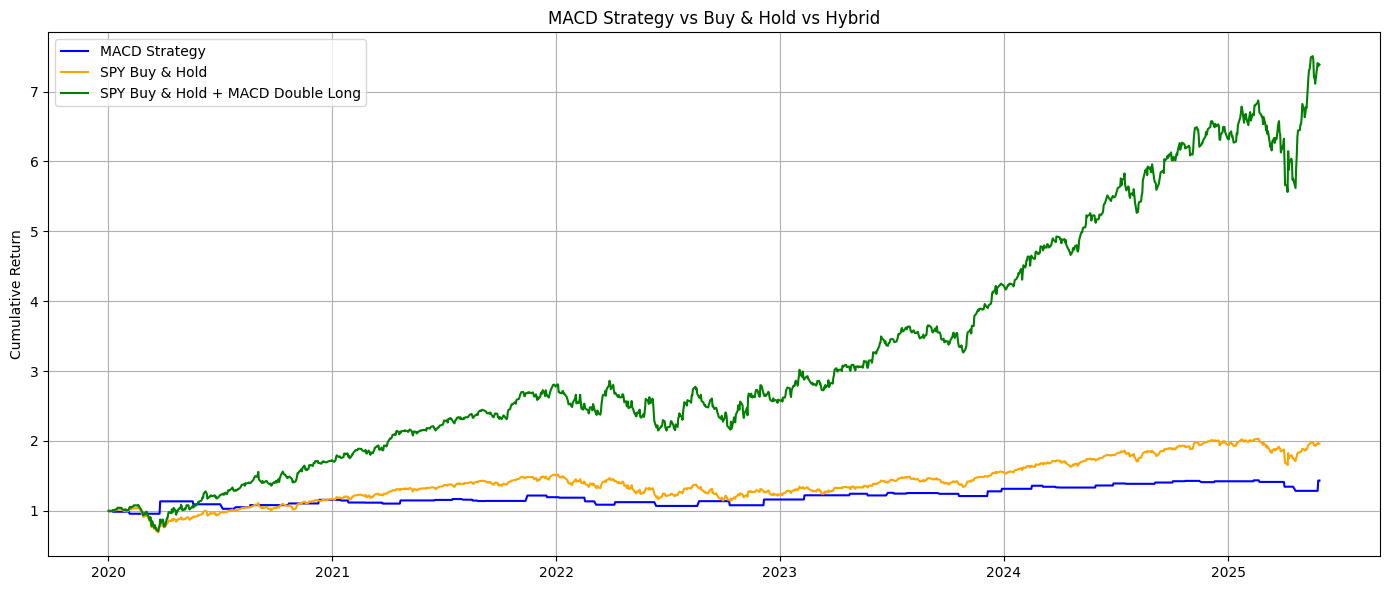

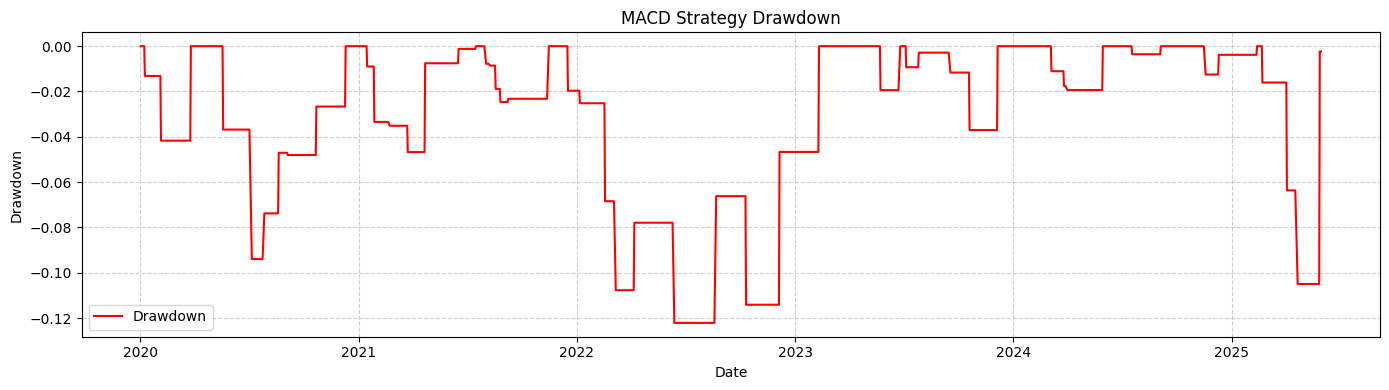


===== Strategy Performance Summary =====
Total Trades: 60
Winning Trades: 29
Losing Trades: 31
Win Rate: 48.33%
MACD Strategy Return: 43.33%
SPY Buy & Hold Return: 96.27%
Hybrid Strategy Return: 638.68%
Hybrid_Return descriptive statistics:
count    1360.000000
mean        0.001649
std         0.018881
min        -0.109424
25%        -0.006840
50%         0.001373
75%         0.010443
max         0.134332
Name: Hybrid_Return, dtype: float64

Largest daily returns (top 10):
Date
2020-04-06    0.134332
2020-03-26    0.116780
2022-11-10    0.109908
2025-04-09    0.105019
2020-03-24    0.090603
2020-03-13    0.085486
2020-04-08    0.067137
2025-05-12    0.066095
2020-03-30    0.064952
2022-11-30    0.063001
Name: Hybrid_Return, dtype: float64

Smallest daily returns (bottom 10):
Date
2020-03-16   -0.109424
2020-03-12   -0.095677
2020-04-01   -0.090009
2020-03-09   -0.078094
2020-09-03   -0.068829
2020-04-21   -0.060726
2020-03-27   -0.059571
2025-04-04   -0.058543
2022-06-10   -0.057991
2

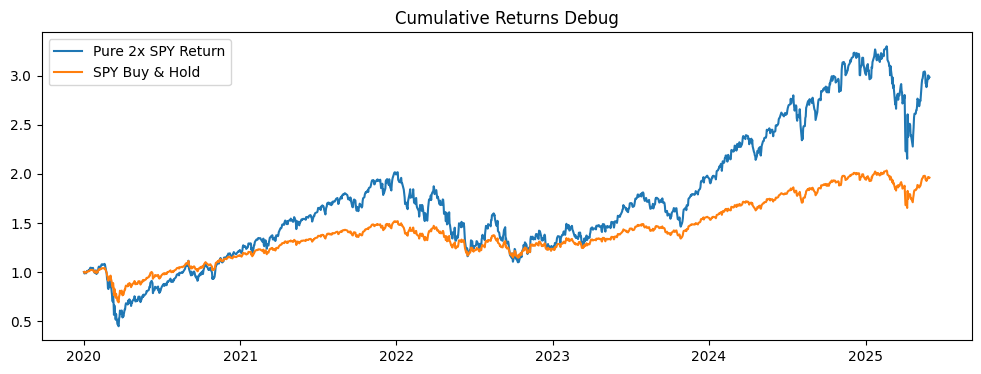

SPY_Return descriptive statistics:
count    1360.000000
mean        0.000588
std         0.013578
min        -0.109424
25%        -0.005162
50%         0.000903
75%         0.007223
max         0.105019
Name: SPY_Return, dtype: float64


In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Parameters
START_DATE = '2020-01-01'
END_DATE = '2025-06-01'
MACD_FAST = 12
MACD_SLOW = 26
MACD_SIGNAL = 9
STOP_LOSS_PCT = 0.05
POSITION_SIZE = 1.0

# 2. Download SPY
spy = yf.download('SPY', start=START_DATE, end=END_DATE, auto_adjust=True)
spy = spy[['Close']].rename(columns={'Close': 'SPY'})
spy.dropna(inplace=True)

# 3. MACD Calculation
ema_fast = spy['SPY'].ewm(span=MACD_FAST, adjust=False).mean()
ema_slow = spy['SPY'].ewm(span=MACD_SLOW, adjust=False).mean()
spy['MACD'] = ema_fast - ema_slow
spy['Signal'] = spy['MACD'].ewm(span=MACD_SIGNAL, adjust=False).mean()

# 4. Backtest
spy['Position'] = 0
spy['In_Trade'] = False
spy['Entry_Price'] = np.nan
spy['Exit_Price'] = np.nan
spy['Trade_Return'] = np.nan
spy['Equity'] = np.nan

in_trade = False
position = 0
entry_price = 0
spy.iloc[0, spy.columns.get_loc('Equity')] = 1.0

for i in range(1, len(spy)):
    macd_today = spy['MACD'].iloc[i].item()
    signal_today = spy['Signal'].iloc[i].item()
    macd_yesterday = spy['MACD'].iloc[i - 1].item()
    signal_yesterday = spy['Signal'].iloc[i - 1].item()
    price_today = spy['SPY'].iloc[i].item()
    previous_equity = spy['Equity'].iloc[i - 1].item()

    # Crossovers
    buy_signal = macd_today > signal_today and macd_yesterday <= signal_yesterday
    sell_signal = macd_today < signal_today and macd_yesterday >= signal_yesterday

    if not in_trade:
        if buy_signal:
            position = 1
            entry_price = price_today
            spy.iloc[i, spy.columns.get_loc('Position')] = position
            spy.iloc[i, spy.columns.get_loc('Entry_Price')] = entry_price
            spy.iloc[i, spy.columns.get_loc('In_Trade')] = True
            in_trade = True
        elif sell_signal:
            position = -1
            entry_price = price_today
            spy.iloc[i, spy.columns.get_loc('Position')] = position
            spy.iloc[i, spy.columns.get_loc('Entry_Price')] = entry_price
            spy.iloc[i, spy.columns.get_loc('In_Trade')] = True
            in_trade = True
        spy.iloc[i, spy.columns.get_loc('Equity')] = previous_equity

    else:
        if position == 1:
            stop_loss_triggered = price_today <= entry_price * (1 - STOP_LOSS_PCT)
            exit_signal = sell_signal
        else:
            stop_loss_triggered = price_today >= entry_price * (1 + STOP_LOSS_PCT)
            exit_signal = buy_signal

        if stop_loss_triggered or exit_signal:
            trade_return = (price_today - entry_price) / entry_price if position == 1 else (entry_price - price_today) / entry_price
            new_equity = previous_equity * (1 + trade_return * POSITION_SIZE)

            spy.iloc[i, spy.columns.get_loc('Exit_Price')] = price_today
            spy.iloc[i, spy.columns.get_loc('Trade_Return')] = trade_return
            spy.iloc[i, spy.columns.get_loc('Equity')] = new_equity

            in_trade = False
            position = 0
            entry_price = 0
        else:
            spy.iloc[i, spy.columns.get_loc('Position')] = position
            spy.iloc[i, spy.columns.get_loc('In_Trade')] = True
            spy.iloc[i, spy.columns.get_loc('Equity')] = previous_equity

# Fill Equity forward
spy['Equity'] = spy['Equity'].ffill()

# 5. Cumulative Returns
# Base SPY returns
spy['SPY_Return'] = spy['SPY'].pct_change().fillna(0)
spy['SPY_Equity'] = (1 + spy['SPY_Return']).cumprod()

# 6. Hybrid SPY w/ extra long exposure when MACD Buy signal is active
spy['Hybrid_Return'] = spy['SPY_Return']  # start with 1x exposure
extra_position = False

for i in range(1, len(spy)):
    macd_today = spy['MACD'].iloc[i].item()
    signal_today = spy['Signal'].iloc[i].item()
    macd_yesterday = spy['MACD'].iloc[i - 1].item()
    signal_yesterday = spy['Signal'].iloc[i - 1].item()
    price_change = spy['SPY_Return'].iloc[i]

    buy_signal = macd_today > signal_today and macd_yesterday <= signal_yesterday
    sell_signal = macd_today < signal_today and macd_yesterday >= signal_yesterday

    if not extra_position:
        if buy_signal:
            extra_position = True
            # 2x exposure = 1 base + 1 extra
            spy.iloc[i, spy.columns.get_loc('Hybrid_Return')] = price_change * 2
        else:
            spy.iloc[i, spy.columns.get_loc('Hybrid_Return')] = price_change
    else:
        if sell_signal:
            extra_position = False
            spy.iloc[i, spy.columns.get_loc('Hybrid_Return')] = price_change
        else:
            spy.iloc[i, spy.columns.get_loc('Hybrid_Return')] = price_change * 2

spy['Hybrid_Equity'] = (1 + spy['Hybrid_Return'].fillna(0)).cumprod()


# 7. Performance Summary
trades = spy[spy['Trade_Return'].notna()]
total_trades = len(trades)
winning_trades = trades[trades['Trade_Return'] > 0]
losing_trades = trades[trades['Trade_Return'] <= 0]
win_rate = len(winning_trades) / total_trades if total_trades > 0 else 0
total_return = spy['Equity'].iloc[-1] - 1
spy_return = spy['SPY_Equity'].iloc[-1] - 1
hybrid_return = spy['Hybrid_Equity'].iloc[-1] - 1

# 8. Plot Results
plt.figure(figsize=(14, 6))
plt.plot(spy.index, spy['Equity'], label='MACD Strategy', color='blue')
plt.plot(spy.index, spy['SPY_Equity'], label='SPY Buy & Hold', color='orange')
plt.plot(spy.index, spy['Hybrid_Equity'], label='SPY Buy & Hold + MACD Double Long', color='green')
plt.title('MACD Strategy vs Buy & Hold vs Hybrid')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Drawdown
spy['Peak'] = spy['Equity'].cummax()
spy['Drawdown'] = (spy['Equity'] - spy['Peak']) / spy['Peak']

plt.figure(figsize=(14, 4))
plt.plot(spy.index, spy['Drawdown'], label='Drawdown', color='red')
plt.title('MACD Strategy Drawdown')
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 10. Performance Output
print("\n===== Strategy Performance Summary =====")
print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {len(winning_trades)}")
print(f"Losing Trades: {len(losing_trades)}")
print(f"Win Rate: {win_rate:.2%}")
print(f"MACD Strategy Return: {total_return:.2%}")
print(f"SPY Buy & Hold Return: {spy_return:.2%}")
print(f"Hybrid Strategy Return: {hybrid_return:.2%}")


# debug
print("\nHybrid_Return descriptive statistics:")
print(spy["Hybrid_Return"].describe())

print("\nLargest daily returns (top 10):")
print(spy["Hybrid_Return"].sort_values(ascending=False).head(10))

print("\nSmallest daily returns (bottom 10):")
print(spy["Hybrid_Return"].sort_values().head(10))

double_days = (spy["Hybrid_Return"] == spy["SPY_Return"] * 2).sum()
print(f"\nNumber of doubled exposure days: {double_days}")

# plot test
spy["Test_Double"] = (1 + spy["SPY_Return"] * 2).cumprod()

plt.figure(figsize=(12,4))
plt.plot(spy.index, spy["Test_Double"], label="Pure 2x SPY Return")
plt.plot(spy.index, spy["SPY_Equity"], label="SPY Buy & Hold")
plt.legend()
plt.title("Cumulative Returns Debug")
plt.show()

print("SPY_Return descriptive statistics:")
print(spy["SPY_Return"].describe())



